In [47]:
'''
Just copying code from Keras Tutorial

#Train a simple deep CNN on the CIFAR10 small images dataset.
It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
'''

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import pickle 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
print("All imported yo.")

All imported yo.


/home/osboxes/anaconda3/envs/ztdl_tesla/lib/python3.6/site-packages/pandas/core/indexes/api.py:87: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


pd_tr shape: (50000, 3073)
tr_y shape: (50000, 1)


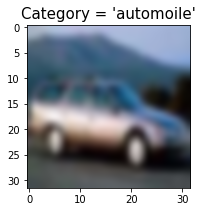

In [58]:
    import re
    
    data_dir = "cifar-10-batches-py"
    
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict1 = pickle.load(fo, encoding='bytes')
        return dict1
     
    pd_tr = pd.DataFrame()
    tr_y = pd.DataFrame()
     
    for i in range(1,6):
        data = unpickle(data_dir + '/data_batch_' + str(i))
        pd_tr = pd_tr.append(pd.DataFrame(data[b'data']))
        tr_y = tr_y.append(pd.DataFrame(data[b'labels']))
        pd_tr['labels'] = tr_y
     
    
    tr_x = np.asarray(pd_tr.iloc[:, :3072])
    tr_y = np.asarray(pd_tr['labels'])
    ts_x = np.asarray(unpickle(data_dir + '/test_batch')[b'data'])
    ts_y = np.asarray(unpickle(data_dir + '/test_batch')[b'labels'])    
    labels = unpickle(data_dir + '/batches.meta')[b'label_names']
     
    def plot_CIFAR(ind):
        arr = tr_x[ind]
        R = arr[0:1024].reshape(32,32)/255.0
        G = arr[1024:2048].reshape(32,32)/255.0
        B = arr[2048:].reshape(32,32)/255.0
     
        img = np.dstack((R,G,B))
        title = re.sub('[!@#$b]', '', str(labels[tr_y[ind]]))
        fig = plt.figure(figsize=(3,3))
        ax = fig.add_subplot(111)
        ax.imshow(img,interpolation='bicubic')
        ax.set_title('Category = '+ title,fontsize =15)
     
    plot_CIFAR(4)

In [2]:
#set parameters

batch_size = 32
num_classes = 10
epochs = 2 #change to 100 in gpu
data_augmentation = False #change to True later
num_predictions = 20
save_dir = os.path.join(os.getcwd(), "saved_models")
model_name = "keras_cifar10_trained_model.h5"

In [90]:
#get data
#(x_train, y_train),(x_test, y_test) = cifar10.load_data()
# x_train shape (50000, 32, 32, 3)
# y_train shape (50000, 1)
# x_test shape (10000, 32, 32, 3)
# y_test shape (10000, 1)

#lets load data from local drive
#for this, cifar10 needs to be downloaded from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

data_dir = "cifar-10-batches-py"
data_files = [file for file in os.listdir(data_dir) if file.startswith("data")]
print(data_files)

test_files = [file for file in os.listdir(data_dir) if file.startswith("test")]
print(test_files)

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

X_train =  []
y_train = []

for data_file in data_files:
    dic = unpickle(os.path.join(data_dir,data_file))
    data = dic[b"data"]
    labels = dic[b"labels"]
    X_train.append(data)
    y_train.append(labels)
    
X_train = np.concatenate(X_train, axis = 0)
print(X_train.shape)
y_train = np.concatenate(y_train, axis = 0)
print(y_train.shape)

X_test =  []
y_test = []

for test_file in test_files:
    dic = unpickle(os.path.join(data_dir,test_file))
    data = dic[b"data"]
    labels = dic[b"labels"]
    X_test.append(data)
    y_test.append(labels)
    
X_test = np.concatenate(X_test, axis = 0)
print(X_test.shape)
y_test = np.concatenate(y_test, axis = 0)
print(y_test.shape)

label_names = unpickle(data_dir + '/batches.meta')[b'label_names']


['data_batch_1', 'data_batch_2', 'data_batch_4', 'data_batch_3', 'data_batch_5']
['test_batch']
(50000, 3072)
(50000,)
(10000, 3072)
(10000,)


In [91]:
#convert class lables to binary class metrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print("y after converting to binary class metrics:")
print(y_train.shape)
print(y_test.shape)


y after converting to binary class metrics:
(50000, 10)
(10000, 10)


In [92]:
#manually check some values

#X has 3072 columns. Not a good idea.
print(y_train[:3, :])
print(y_test[:3, :])


yTemp = np.argmax(y_train, axis=1)
print(yTemp.shape)
print(yTemp[:3])




[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
(50000,)
[6 9 9]


[[170 168 177 ... 162 158 157]
 [168 172 171 ... 159 156 154]
 [154 149 129 ... 161 157 154]
 ...
 [ 74  76  78 ...  71  68  61]
 [ 68  69  72 ...  76  71  71]
 [ 67  68  69 ...  75  71  73]]
img shape: (32, 32, 3)


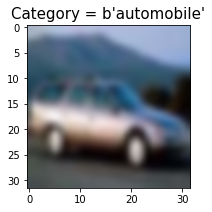

In [97]:
#try visualizing here
#code copied from online. Pretty straightforward.

def plot_CIFAR(ind):
    arr = X_train[ind]
    R = arr[0:1024].reshape(32,32)
    print(R)
    G = arr[1024:2048].reshape(32,32)
    B = arr[2048:].reshape(32,32)

    img = np.dstack((R,G,B))
    print("img shape:", img.shape)
    #title = re.sub('[!@#$b]', '', str(label_names[np.argmax(y_train[ind])]))
    title = str(label_names[np.argmax(y_train[ind])])
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    ax.imshow(img,interpolation='bicubic')
    ax.set_title('Category = '+ title,fontsize =15)

plot_CIFAR(4)

In [105]:
#reshape the X values to *,32,32,3
X_train = X_train.reshape(X_train.shape[0],32,32,3)
X_test = X_test.reshape(X_test.shape[0],32,32,3)
print("X after reshaping:")
print(X_train.shape)
print(X_test.shape)

X after reshaping:
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [106]:
# #for X, can we see an image?

# #was having trouble to vizualize before.
# #this was because we were reshaping data as 32*32*3.
# #After switching to 3*32*32, color channel separation got easier.

# def plot_CIFAR(data, idx):
#     arr = data[idx, :]
#     print(arr.shape)
#     #     R = arr[0:1024].reshape(32,32)/255.0
#     #     G = arr[1024:2048].reshape(32,32)/255.0
#     #     B = arr[2048:].reshape(32,32)/255.0
#     R = arr[0, :, :]
#     G = arr[1, :, :]
#     B = arr[2, :, :]
    
#     img = np.dstack((R,G,B)) #stack arrays along the depth axis (last axis)
#     print("img shape", img.shape)
    
#     title = str(label_names[np.argmax(y_train[idx])])
#     fig = plt.figure(figsize=(3,3))
#     ax = fig.add_subplot(111)
#     ax.imshow(img,interpolation='bicubic')
#     ax.set_title('Category = '+ title,fontsize =15)
    
# plot_CIFAR(X_train, 4)

In [107]:
## create model

model = Sequential()

model.add(Conv2D(32, (3,3), padding = "same", input_shape = X_train.shape[1:], activation = "relu"))
model.add(Conv2D(32, (3,3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3), padding = "same",  activation = "relu"))
model.add(Conv2D(32, (3,3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = "softmax"))

#initialize rmsprop optimizer
opt = keras.optimizers.rmsprop(lr = 0.0001, decay = 1e-6)

#train the model using rpsprop
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 32)        9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
__________

In [46]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255



In [47]:
if not data_augmentation:
    print("Not using data augmentation.")
    model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_test, y_test), shuffle = True, verbose = 1)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(X_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        workers=4)

#save model and weights
if not os.path.isdir(savedir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print("saved trained model at {}".format(model_path) )

#score trained model
scores = model.evaluate(X_test, y_test, verbose = 1)
print("test loss:", scores[0])
print("test accuracy:", scores[1])

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/2
12416/50000 [======>.......................] - ETA: 751s - loss: 2.2770 - acc: 0.1576

KeyboardInterrupt: 